# Summarize experimental data

In [28]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Set the theme for seaborn plots
sns.set_theme(style="white")

In [29]:
group_colors = {
    'male': '#D7301F',  # Vibrant red with an orangish hue (for males)
    'female': '#F4A40B',  # Strong yellow (for females)
    'atoke': '#654321'   # Duller brown (for atokes)
}

### V log I

In [30]:
# Load and process VlogI data
VlogI_df = pd.read_csv('../data/Pd_VlogI.csv')
VlogI_df['Condition'] = VlogI_df['Group'] + "_" + VlogI_df['EyePosition']
VlogI_df['Recording'] = VlogI_df['id'] + "_" + VlogI_df['Group'] + "_" + VlogI_df['EyePosition']
VlogI_df['Recording'] = VlogI_df['Recording'].astype('category')
VlogI_df['logI_scaled'] = (VlogI_df['logI'] - VlogI_df['logI'].mean()) / VlogI_df['logI'].std()
VlogI_df.head()

,logI,ID,id,Recorder,Group,EyePosition,Response,Condition,Recording,logI_scaled
0,2.4,jjb03,v_a1,JJB,atoke,posterior,0.887097,atoke_posterior,v_a1_atoke_posterior,1.643658
1,1.7,jjb03,v_a1,JJB,atoke,posterior,0.919355,atoke_posterior,v_a1_atoke_posterior,1.318231
2,1.4,jjb03,v_a1,JJB,atoke,posterior,1.000000,atoke_posterior,v_a1_atoke_posterior,1.178763
3,0.7,jjb03,v_a1,JJB,atoke,posterior,0.790323,atoke_posterior,v_a1_atoke_posterior,0.853336
4,0.4,jjb03,v_a1,JJB,atoke,posterior,0.919355,atoke_posterior,v_a1_atoke_posterior,0.713867


In [31]:
# Grouped summary by condition
VlogI_grouped = VlogI_df.groupby('Condition').agg(
    id=('id', 'nunique'),
    Recordings=('Recording', 'nunique'),
    EyePosition=('EyePosition', 'nunique'),
    Group=('Group', 'nunique')
)
VlogI_grouped

,id,Recordings,EyePosition,Group
Condition,,,,
atoke_anterior,9,9,1,1
atoke_posterior,10,10,1,1
female_anterior,3,3,1,1
female_posterior,4,4,1,1
male_anterior,8,8,1,1
male_posterior,4,4,1,1


In [32]:
# ** V-Log I curves were interpolated from 9 anterior and 11 posterior atoke eyes, 8 anterior and 5 posterior male epitoke eyes, and 3 anterior and 4 posterior female epitoke eyes.**
VlogI_df.groupby('Recording').first().groupby('Condition').size()

C:\Users\seano\AppData\Local\Temp\ipykernel_19196\2297294346.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  VlogI_df.groupby('Recording').first().groupby('Condition').size()


Condition
atoke_anterior       9
atoke_posterior     10
female_anterior      3
female_posterior     4
male_anterior        8
male_posterior       4
dtype: int64

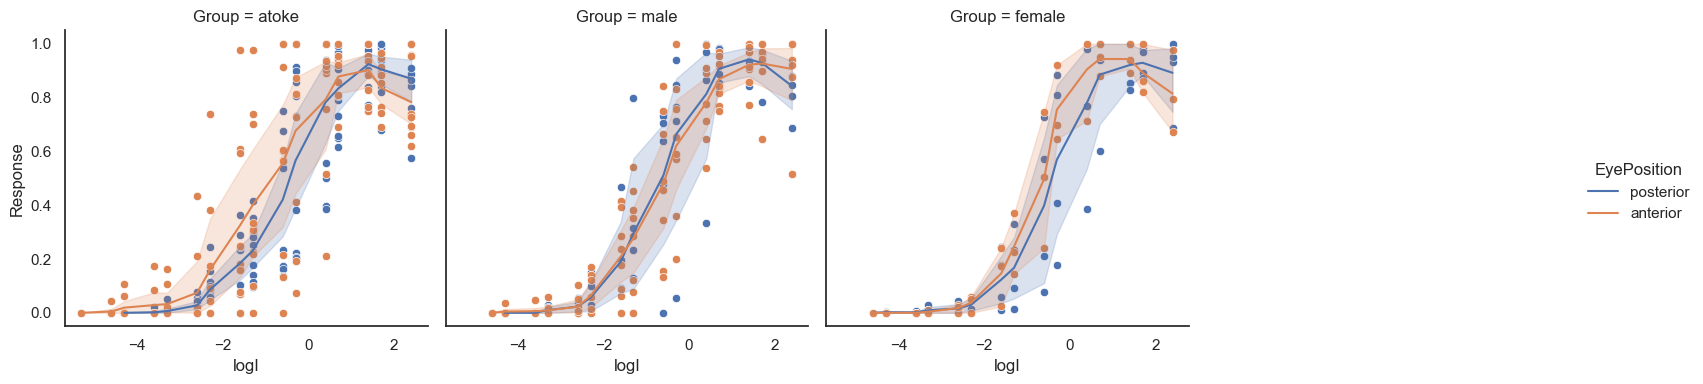

In [33]:
# Plotting data by Recording and EyePosition
g = sns.FacetGrid(VlogI_df, col="Group", hue="EyePosition", col_wrap=4, height=4)
g.map(sns.scatterplot, "logI", "Response")
g.map(sns.lineplot, "logI", "Response")
g.add_legend()
sns.despine()
plt.show()

In [34]:
VlogI_df.describe()

,logI,Response,logI_scaled
count,588.000000,588.000000,5.880000e+02
mean,-1.135544,0.414480,3.398642e-17
std,2.151022,0.403659,1.000000e+00
min,-5.300000,0.000000,-1.936036e+00
25%,-3.300000,0.000000,-1.006245e+00
50%,-1.300000,0.241694,-7.645473e-02
75%,0.700000,0.856573,8.533360e-01
max,2.400000,1.000000,1.643658e+00


### Liminal absolute sensitivity

C:\Users\seano\AppData\Local\Temp\ipykernel_19196\2855616754.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  liminal_df = VlogI_df_sorted[VlogI_df_sorted['Response'] > 0.05].groupby(['Recording']).agg(
C:\Users\seano\AppData\Local\Temp\ipykernel_19196\2855616754.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(  x='Group', y='logI', data=liminal_df, palette=group_colors)


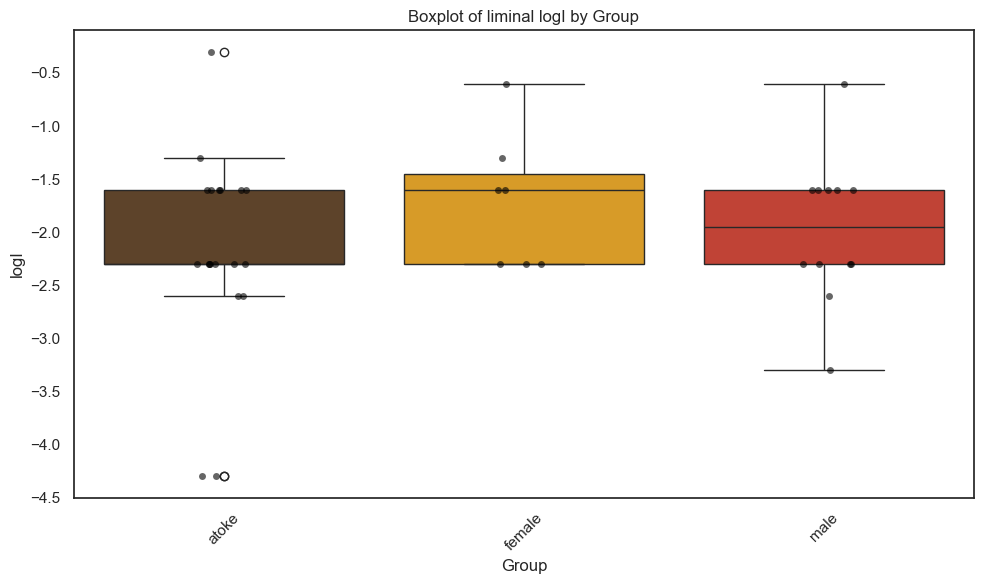

In [35]:
# Sort the DataFrame by 'freq_Hz'
VlogI_df_sorted = VlogI_df.sort_values('logI')

# Get the rows with the largest reponse below the threshold
liminal_df = VlogI_df_sorted[VlogI_df_sorted['Response'] > 0.05].groupby(['Recording']).agg(
    logI=('logI', 'first'), Response=('Response', 'first'))

# Reset index to make 'Recording' and 'freq_Hz' regular columns again
liminal_df = liminal_df.reset_index()

liminal_df = liminal_df.merge(VlogI_df_sorted[['Recording', 'logI', 'id', 'Condition', 'Recorder', 'Group']], on=['Recording','logI'], how='left')
liminal_df = liminal_df.drop_duplicates(subset=['Recording', 'logI'])

Hz_mean = liminal_df['logI'].mean()
Hz_std  = liminal_df['logI'].std()
liminal_df['logI_scaled'] = (liminal_df['logI'] - Hz_mean) / Hz_std

# Plot boxplot of logI by Group
plt.figure(figsize=(10, 6))
sns.boxplot(  x='Group', y='logI', data=liminal_df, palette=group_colors)
sns.stripplot(x='Group', y='logI', data=liminal_df, color='black', jitter=True, alpha=0.6)
plt.title('Boxplot of liminal logI by Group')
plt.xlabel('Group')
plt.ylabel('logI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\seano\AppData\Local\Temp\ipykernel_19196\1077772086.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medial_df = VlogI_df_sorted[VlogI_df_sorted['Response'] >= 0.5].groupby(['Recording']).agg(
C:\Users\seano\AppData\Local\Temp\ipykernel_19196\1077772086.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(  x='Group', y='logI', data=medial_df,  palette=group_colors)


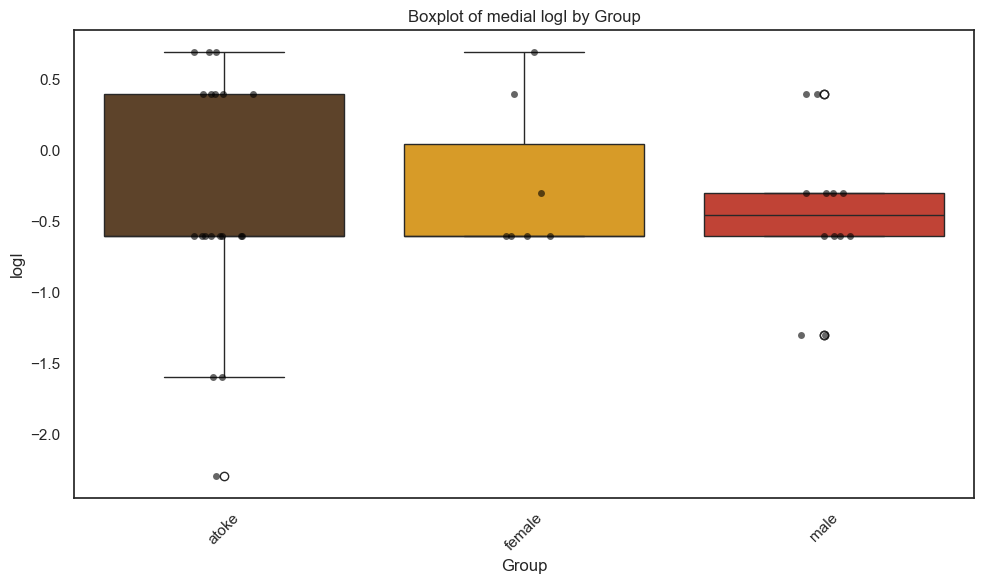

In [36]:
# Sort the DataFrame by 'freq_Hz'
VlogI_df_sorted = VlogI_df.sort_values('logI')

# Get the rows with the largest reponse below the threshold
medial_df = VlogI_df_sorted[VlogI_df_sorted['Response'] >= 0.5].groupby(['Recording']).agg(
    logI=('logI', 'first'), Response=('Response', 'first'))

# Reset index to make 'Recording' and 'freq_Hz' regular columns again
medial_df = medial_df.reset_index()

medial_df = medial_df.merge(VlogI_df_sorted[['Recording', 'logI', 'id', 'Condition', 'Recorder', 'Group']], on=['Recording','logI'], how='left')
medial_df = medial_df.drop_duplicates(subset=['Recording', 'logI'])

Hz_mean = medial_df['logI'].mean()
Hz_std  = medial_df['logI'].std()
medial_df['logI_scaled'] = (medial_df['logI'] - Hz_mean) / Hz_std

# Plot boxplot of logI by Group
plt.figure(figsize=(10, 6))
sns.boxplot(  x='Group', y='logI', data=medial_df,  palette=group_colors)
sns.stripplot(x='Group', y='logI', data=medial_df, color='black', jitter=True, alpha=0.6)
plt.title('Boxplot of medial logI by Group')
plt.xlabel('Group')
plt.ylabel('logI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Spectral Data Analysis

In [37]:
# Load and process Spectral data
spectral_df = pd.read_csv('../data/Pd_spectral_sensitivity.csv')
spectral_df['Condition'] = spectral_df['Group'].astype(str) + spectral_df['EyePosition']
spectral_df['Recording'] = spectral_df['id'].astype(str) + spectral_df['Group'].astype(str) + spectral_df['EyePosition']
spectral_df.head()

,WV,ID,Observer,id,Group,EyePosition,Response,Condition,Recording
0,420,ag01,AG,s_a1,atoke,posterior,0.158284,atokeposterior,s_a1atokeposterior
1,430,ag01,AG,s_a1,atoke,posterior,0.375037,atokeposterior,s_a1atokeposterior
2,440,ag01,AG,s_a1,atoke,posterior,0.529754,atokeposterior,s_a1atokeposterior
3,450,ag01,AG,s_a1,atoke,posterior,0.594393,atokeposterior,s_a1atokeposterior
4,460,ag01,AG,s_a1,atoke,posterior,0.748297,atokeposterior,s_a1atokeposterior


In [38]:
# Grouped summary by condition
spectral_grouped = spectral_df.groupby('Condition').agg(
    id=('id', 'nunique'),
    Recordings=('Recording', 'nunique'),
    EyePosition=('EyePosition', 'nunique'),
    Group=('Group', 'nunique')
)
spectral_grouped

,id,Recordings,EyePosition,Group
Condition,,,,
atokeanterior,6,6,1,1
atokeposterior,8,8,1,1
femaleanterior,3,3,1,1
femaleposterior,4,4,1,1
maleanterior,9,9,1,1
maleposterior,3,3,1,1


### FFF Data Analysis

In [39]:
# Load and process FFF data
fff_df = pd.read_csv('./../data/Pd_FFF.csv')
fff_df['Condition'] = fff_df['Group'].astype(str) + fff_df['EyePosition']
fff_df['Recording'] = fff_df['id'].astype(str) + fff_df['Group'].astype(str) + fff_df['EyePosition']
fff_df.tail()

,freq_Hz,ID,id,Observer,Group,EyePosition,Response,Condition,Recording
364,7.5,ag 06,f_f7,AG,female,anterior,0.103896,femaleanterior,f_f7femaleanterior
365,8.5,ag 06,f_f7,AG,female,anterior,0.155844,femaleanterior,f_f7femaleanterior
366,9.5,ag 06,f_f7,AG,female,anterior,0.038961,femaleanterior,f_f7femaleanterior
367,10.5,ag 06,f_f7,AG,female,anterior,0.025974,femaleanterior,f_f7femaleanterior
368,11.5,ag 06,f_f7,AG,female,anterior,0.038961,femaleanterior,f_f7femaleanterior


In [40]:
# Grouped summary by condition
fff_grouped = fff_df.groupby('Condition').agg(
    id=('id', 'nunique'),
    Recordings=('Recording', 'nunique'),
    EyePosition=('EyePosition', 'nunique'),
    Group=('Group', 'nunique')
)
fff_grouped

,id,Recordings,EyePosition,Group
Condition,,,,
atokeanterior,6,6,1,1
atokeposterior,7,7,1,1
femaleanterior,3,3,1,1
femaleposterior,4,4,1,1
maleanterior,7,7,1,1
maleposterior,4,4,1,1


## Pupil dynamic

In [41]:
# Load the data and exclude times exceeding 35 minutes
eye_measures_um_df = pd.read_csv('../data/Platynereis_eye_pupil.csv', sep = ',')
eye_measures_um_df = eye_measures_um_df[eye_measures_um_df['time'] <= 35]
eye_measures_um_df.tail()

,structure,group,id,date,side,time,area,perimeter,major,minor,feret,minFeret
80,pupil,male,male3,30_08_23,only,0,1495,151.938,46.690,40.769,47.170,40.806
81,pupil,male,male3,30_08_23,only,5,1621,168.977,50.455,40.906,51.865,40.000
82,pupil,male,male3,30_08_23,only,10,1210,140.741,43.085,35.758,45.591,37.000
83,pupil,male,male3,30_08_23,only,20,2593,207.954,62.672,52.679,62.936,51.000
84,pupil,male,male3,30_08_23,only,30,2593,207.954,62.672,52.679,62.936,51.000


In [42]:
# Group by 'id' and calculate the mean for the 'major' column
eye_measures_um_df_grouped = eye_measures_um_df.groupby(['id'])['major'].mean().reset_index()

# Display the grouped DataFrame
eye_measures_um_df_grouped

,id,major
0,atoke1,64.2866
1,atoke2,70.3020
2,atoke3,87.9084
3,female1,110.1192
4,female2,112.2414
5,female3,69.5208
6,male1,45.8864
7,male2,166.8976
8,male3,53.1148
